In [1]:
%matplotlib inline

import pickle

from keras.datasets import mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

/home/qkt/.local/share/virtualenvs/sgan-techniques-WxACZbr4/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
sns.set_style('whitegrid')

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_test = (x_test.astype(np.float32) - 127.5) / 127.5

x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

In [4]:
def dense_discriminator(x, is_training, num_classes=10, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse) as scope:
        x = tf.layers.flatten(x)
        x = tf.layers.dense(x, 512, activation=tf.nn.leaky_relu)
        x = tf.layers.dense(x, 256, activation=tf.nn.leaky_relu)
        features = tf.layers.dense(x, 128, activation=tf.nn.leaky_relu)
        logits = tf.layers.dense(features, num_classes + 1)
        output = tf.nn.softmax(logits)
        return output, logits, features

In [5]:
def dense_generator(x, is_training, output_shape=(28, 28, 1), reuse=False):
    with tf.variable_scope('generator', reuse=reuse) as scope:
        x = tf.layers.dense(x, 256, activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.layers.dense(x, 512, activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.layers.dense(x, 1024, activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.layers.dense(x, np.prod(output_shape), activation=tf.nn.tanh)
        x = tf.reshape(x, (-1,) + output_shape)
        
        return x

In [6]:
def build_dense_model(x_real, z, is_training, num_classes=10, output_shape=(28, 28, 1)):
    d_real_prob, d_real_logits, d_real_features = dense_discriminator(
        x_real, is_training, num_classes=num_classes, reuse=False,
    )
    x_fake = dense_generator(z, is_training, output_shape=output_shape)
    d_fake_prob, d_fake_logits, d_fake_features = dense_discriminator(
        x_fake, is_training, num_classes=num_classes, reuse=True,
    )
    return d_real_prob, d_real_logits, d_real_features, d_fake_prob, d_fake_logits, d_fake_features, x_fake

In [7]:
def calculate_squared_distances(a, b):
    na = tf.shape(a)[0]
    nb = tf.shape(b)[0]
    a = tf.reshape(a, [na, 1, -1])
    b = tf.reshape(b, [1, nb, -1])
    a = tf.tile(a, [1, nb, 1])
    b = tf.tile(b, [na, 1, 1])
    d = a - b
    return tf.reduce_sum(tf.square(d), axis=-1)

In [8]:
def plummer_kernel(a, b, dimension, epsilon):
    r = calculate_squared_distances(a, b)
    r += epsilon * epsilon
    f1 = dimension - 2
    return tf.pow(r, -f1 / 2)

In [9]:
def get_potentials(x, y, dimension=3, epsilon=1.0):
    x_fixed = tf.stop_gradient(x)
    y_fixed = tf.stop_gradient(y)
    
    pk_xx = plummer_kernel(x_fixed, x, dimension, epsilon)
    pk_yx = plummer_kernel(y, x, dimension, epsilon)
    pk_yy = plummer_kernel(y_fixed, y, dimension, epsilon)
    
    kxx = tf.reduce_mean(pk_xx, axis=0)
    kyx = tf.reduce_mean(pk_yx, axis=0)
    kxy = tf.reduce_mean(pk_yx, axis=1)
    kyy = tf.reduce_mean(pk_yy, axis=0)
    
    pot_x = kxx - kyx
    pot_y = kxy - kyy
    
    pot_x = tf.reshape(pot_x, [-1])
    pot_y = tf.reshape(pot_y, [-1])
    return pot_x, pot_y

In [10]:
def coulomb_loss_accuracy(x_real, x_fake, d_real_prob, d_real_logits,
                          d_fake_prob, d_fake_logits, extended_label, labeled_mask):
    epsilon = 1e-8
    
    ### Supervised loss for discriminator
    d_ce = tf.nn.softmax_cross_entropy_with_logits_v2(logits=d_real_logits,
                                                      labels=extended_label)
    d_loss_supervised = tf.reduce_sum(labeled_mask * d_ce) / (tf.reduce_sum(labeled_mask) + epsilon)
    
    ### Coulomb GAN loss
    y_real = d_real_logits[:, -1]
    y_fake = d_fake_logits[:, -1]
    pot_fake, pot_real = get_potentials(x_fake, x_real)
    d_loss_real = tf.losses.mean_squared_error(pot_real, y_real)
    d_loss_fake = tf.losses.mean_squared_error(pot_fake, y_fake)
    d_loss_unsupervised = d_loss_real + d_loss_fake
    
    d_loss = d_loss_supervised + d_loss_unsupervised
    
    g_loss = tf.reduce_mean(y_fake)
    
    ### Accuracy
    correct_prediction = tf.equal(tf.argmax(d_real_prob[:, :-1], 1),
                                  tf.argmax(extended_label[:, :-1], 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return d_loss_supervised, d_loss_real, d_loss_fake, d_loss, g_loss, accuracy

In [11]:
def optimizer(d_loss, g_loss, d_learning_rate, g_learning_rate):
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        all_vars = tf.trainable_variables()
        d_vars = [var for var in all_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in all_vars if var.name.startswith('generator')]

        d_optimizer = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        g_optimizer = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        return d_optimizer, g_optimizer

In [12]:
def extend_labels(labels):
    # add extra label for fake data
    extended_label = tf.concat([labels, tf.zeros([tf.shape(labels)[0], 1])], axis=1)

    return extended_label

In [13]:
def moving_average(x, n=10):
    ret = np.cumsum(x)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [14]:
def execute(x_train, y_train, x_test, y_test,
            epochs=50000, batch_size=32, test_steps=500, num_labeled_examples=None, 
            periodic_labeled_batch=False, periodic_labeled_batch_frequency=10,
            x_height=28, x_width=28, num_channels=1, latent_size=100):
    tf.reset_default_graph()
    
    num_classes = np.unique(y_train).shape[0]
    y_test = to_categorical(y_test, num_classes=num_classes)
    default_learning_rate = 0.001
    
    x = tf.placeholder(tf.float32, name='x', shape=(None, x_height, x_width, num_channels))
    label = tf.placeholder(tf.float32, name='label', shape=(None, num_classes))
    labeled_mask = tf.placeholder(tf.float32, name='labeled_mask', shape=(None,))
    z = tf.placeholder(tf.float32, name='z', shape=(None, latent_size))
    is_training = tf.placeholder(tf.bool, name = 'is_training')
    g_learning_rate = tf.placeholder(tf.float32, name='g_learning_rate')
    d_learning_rate = tf.placeholder(tf.float32, name='d_learning_rate')
    
    model = build_dense_model(x, z, is_training)
    extended_label = extend_labels(label)
    d_real_prob, d_real_logits, d_real_features, d_fake_prob, d_fake_logits, d_fake_features, x_fake = model
    loss_acc = coulomb_loss_accuracy(x, x_fake, d_real_prob, d_real_logits,
                                     d_fake_prob, d_fake_logits, extended_label, labeled_mask)
    _, _, _, d_loss, g_loss, accuracy = loss_acc
    d_optimizer, g_optimizer = optimizer(d_loss, g_loss, d_learning_rate, g_learning_rate)
    
    if num_labeled_examples is None:
        global_mask = np.ones(x_train.shape[0])
        periodic_labeled_batch = False
    else:
        global_mask = np.zeros(x_train.shape[0])
        for cls in np.unique(y_train):
            idx = y_train == cls
            idx = np.random.choice(np.flatnonzero(idx), num_labeled_examples // num_classes, replace=False)
            global_mask[idx] = 1.0
        
    
    train_d_losses, train_g_losses, train_accuracies = [], [], []
    test_d_losses, test_g_losses, test_accuracies = [], [], []
    
    def test_gan(epoch):
        d_batch_losses, g_batch_losses, batch_accuracies = [], [], []
        
        test_size = x_test.shape[0]
        batch_size = test_size // 100
        test_mask = np.ones(test_size)
        for i in range(0, test_size, batch_size):
            z_test = np.random.normal(0, 1, (batch_size, latent_size))
            test_mask = np.ones(test_size)
            test_dictionary = {
                x: x_test[i:i+batch_size],
                z: z_test,
                label: y_test[i:i+batch_size],
                labeled_mask: test_mask[i:i+batch_size],
                is_training: False
            }

            test_d_loss = d_loss.eval(feed_dict=test_dictionary)
            test_g_loss = g_loss.eval(feed_dict=test_dictionary)
            test_accuracy = accuracy.eval(feed_dict=test_dictionary)
            
            d_batch_losses.append(test_d_loss)
            g_batch_losses.append(test_g_loss)
            batch_accuracies.append(test_accuracy)

        test_d_loss = np.mean(d_batch_losses)
        test_g_loss = np.mean(g_batch_losses)
        test_accuracy = np.mean(batch_accuracies)
        
        test_d_losses.append(test_d_loss)
        test_g_losses.append(test_g_loss)
        test_accuracies.append(test_accuracy)

        print(epoch, test_d_loss, test_g_loss, test_accuracy)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch in range(epochs):
            if periodic_labeled_batch and epoch % periodic_labeled_batch_frequency == 0:
                idx = np.flatnonzero(global_mask)
                x_batch = x_train[idx]
                y_batch = y_train[idx]
                mask = global_mask[idx]
                z_batch = np.random.normal(0, 1, (len(idx), latent_size))
                
                x_batches = [x_batch[i:i+batch_size] for i in range(0, len(x_batch), batch_size)]
                y_batches = [y_batch[i:i+batch_size] for i in range(0, len(y_batch), batch_size)]
                masks = [mask[i:i+batch_size] for i in range(0, len(mask), batch_size)]
                z_batches = [z_batch[i:i+batch_size] for i in range(0, len(z_batch), batch_size)]
                
                learning_rate = default_learning_rate / len(x_batches)
            else:
                idx = np.random.randint(0, x_train.shape[0], batch_size)
                x_batch = x_train[idx]
                y_batch = y_train[idx]
                mask = global_mask[idx]
                z_batch = np.random.normal(0, 1, (batch_size, latent_size))
                
                x_batches = [x_batch]
                y_batches = [y_batch]
                masks = [mask]
                z_batches = [z_batch]
                
                learning_rate = default_learning_rate
            
            train_d_loss_batches, train_g_loss_batches, train_accuracy_batches = [], [], []
            for x_batch, y_batch, mask, z_batch in zip(x_batches, y_batches, masks, z_batches):
                y_batch = to_categorical(y_batch, num_classes=num_classes)
                train_dictionary = {
                    x: x_batch,
                    z: z_batch,
                    label: y_batch,
                    labeled_mask: mask,
                    g_learning_rate: learning_rate,
                    d_learning_rate: learning_rate,
                    is_training: True
                }
                d_optimizer.run(feed_dict=train_dictionary)
                g_optimizer.run(feed_dict=train_dictionary)

                train_d_loss = d_loss.eval(feed_dict=train_dictionary)
                train_g_loss = g_loss.eval(feed_dict=train_dictionary)
                train_accuracy = accuracy.eval(feed_dict=train_dictionary)
                
                train_d_loss_batches.append(train_d_loss)
                train_g_loss_batches.append(train_g_loss)
                train_accuracy_batches.append(train_accuracy)
            
            train_d_losses.append(np.mean(train_d_loss_batches))
            train_g_losses.append(np.mean(train_g_loss_batches))
            train_accuracies.append(np.mean(train_accuracy_batches))
            
            if epoch % test_steps == 0:
                test_gan(epoch)
        test_gan(epochs)
    
    return train_d_losses, train_g_losses, train_accuracies, test_d_losses, test_g_losses, test_accuracies

In [15]:
def run_test(output_file, num_labeled_examples=None,
             periodic_labeled_batch=False, periodic_labeled_batch_frequency=10):
    results = execute(x_train, y_train, x_test, y_test, num_labeled_examples=num_labeled_examples,
                      periodic_labeled_batch=periodic_labeled_batch,
                      periodic_labeled_batch_frequency=periodic_labeled_batch_frequency)
    train_d_losses, train_g_losses, train_accuracies, test_d_losses, test_g_losses, test_accuracies = results
    with open(output_file, 'wb') as f:
        pickle.dump({
            'train_d_losses': train_d_losses,
            'train_g_losses': train_g_losses,
            'train_accuracies': train_accuracies,
            'test_d_losses': test_d_losses,
            'test_g_losses': test_g_losses,
            'test_accuracies': test_accuracies
        }, f)
    return results

In [16]:
def plot_losses(results):
    train_d_losses, train_g_losses, _, test_d_losses, test_g_losses, _ = results
    
    average_train_d_losses = moving_average(train_d_losses, 10)
    average_train_g_losses = moving_average(train_g_losses, 10)

    plt.figure(figsize=(15, 8))
    plt.plot(np.arange(len(average_train_d_losses)), average_train_d_losses, label='discriminator training loss')
    plt.plot(np.arange(len(average_train_g_losses)), average_train_g_losses, label='generator training loss')
    plt.plot(np.arange(len(test_d_losses)) * 500, test_d_losses, label='discriminator test loss')
    plt.plot(np.arange(len(test_g_losses)) * 500, test_g_losses, label='generator test loss')
    plt.legend()

In [17]:
def plot_accuracies(results):
    _, _, train_accuracies, _, _, test_accuracies = results
    
    average_train_accuracies = moving_average(train_accuracies, 10)

    plt.figure(figsize=(15, 8))
    plt.plot(np.arange(len(average_train_accuracies)), average_train_accuracies, label='training accuracy')
    plt.plot(np.arange(len(test_accuracies)) * 500, test_accuracies, label='test accuracy')
    plt.legend()

In [18]:
results = run_test('coulomb-gan-all.pkl')

0 49.415016 -0.16631441 0.123100005
500 0.3155234 0.016959287 0.9108999
1000 0.21225624 0.0059866835 0.93600005
1500 0.18561903 0.039926298 0.94660014
2000 0.17017789 0.04609798 0.9504
2500 0.16828743 0.024249032 0.95269996
3000 0.16583997 0.050379604 0.9522
3500 0.16687796 0.015104877 0.9534
4000 0.1721705 0.02968078 0.9478
4500 0.1517064 0.04958837 0.95489997
5000 0.13386664 0.010224019 0.96049994
5500 0.19948764 0.05519721 0.9453
6000 0.1808102 0.07006227 0.94939995
6500 0.1863133 0.0253918 0.9484
7000 0.1603573 0.037620217 0.9591
7500 0.13529074 0.005453199 0.96209997
8000 0.1354877 0.0017558106 0.96269995
8500 0.1544538 0.04015815 0.96210015
9000 0.110955134 0.035621107 0.9683999
9500 0.16560376 0.008195585 0.95619994
10000 0.15496382 0.028102413 0.95719993
10500 0.15633526 0.028670155 0.9552
11000 0.14993827 0.022113407 0.95979995
11500 0.12817344 0.07071369 0.9667999
12000 0.16002485 0.0074489973 0.96309996
12500 0.12045665 0.012346946 0.9689999
13000 0.17180942 0.013845208 0.95

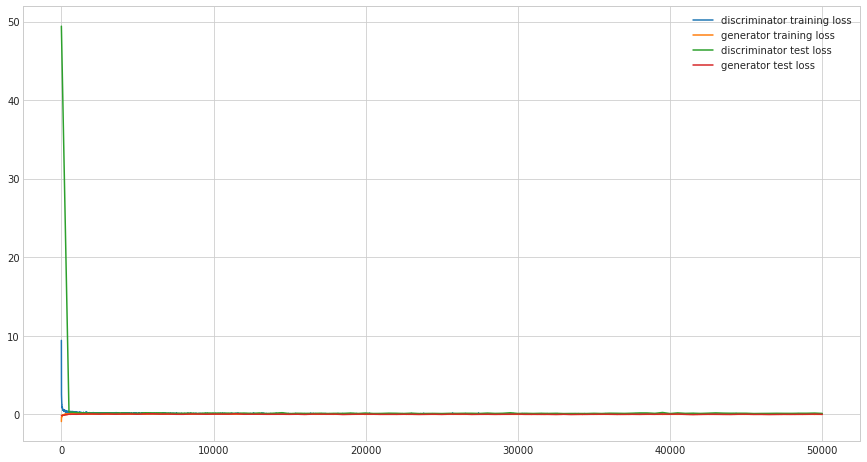

In [19]:
plot_losses(results)

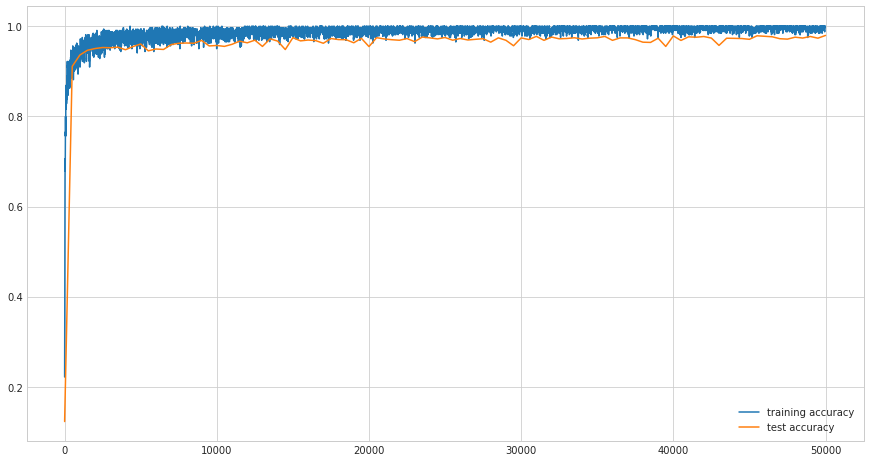

In [20]:
plot_accuracies(results)

In [21]:
results = run_test('coulomb-gan-100-periodic.pkl', num_labeled_examples=100, periodic_labeled_batch=True)

0 3.0492797 -0.071434535 0.14000002
500 2.6128302 -0.011747891 0.40999997
1000 0.9671799 0.015794056 0.7138001
1500 0.8709289 0.0163834 0.72540003
2000 0.8944526 0.015393728 0.7284
2500 0.8819575 -0.00855161 0.7261999
3000 0.91428435 0.021487767 0.7186001
3500 0.8451895 0.015781548 0.7416
4000 0.9169279 0.023302067 0.7214
4500 1.0641054 0.013335765 0.6974
5000 1.1359539 0.031116799 0.7116999
5500 1.111078 0.0053426153 0.7149001
6000 1.1409009 0.03487871 0.7132001
6500 1.073153 0.029878855 0.7093
7000 1.1224955 0.043559242 0.7202001
7500 1.1517022 0.049235724 0.72
8000 1.1700872 0.045681283 0.71950006
8500 1.1450084 0.05743383 0.72450006
9000 1.6386933 0.07028427 0.72870004
9500 1.2105151 0.05055532 0.7286
10000 1.2372481 -0.015938615 0.6577999
10500 1.2815777 -0.0056318585 0.6830999
11000 1.3450226 0.024786318 0.6887
11500 1.4927739 0.04866695 0.69360006
12000 1.6931664 0.08507104 0.6974
12500 1.5195547 0.09065302 0.7009
13000 1.5154905 0.08400364 0.7003
13500 1.5402569 0.054952268 0.6

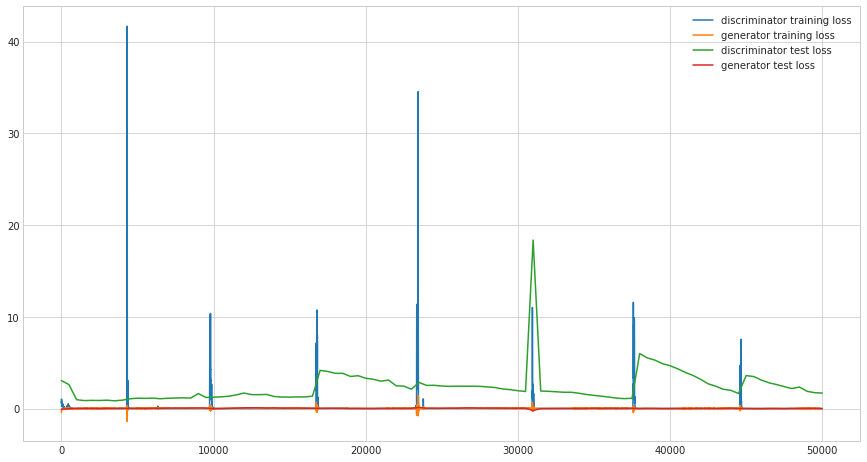

In [22]:
plot_losses(results)

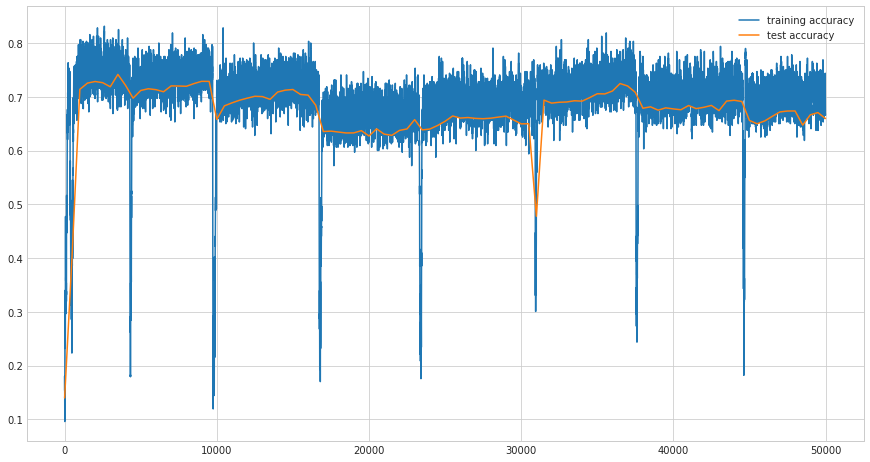

In [23]:
plot_accuracies(results)

In [24]:
results = run_test('coulomb-gan-300-periodic.pkl', num_labeled_examples=300, periodic_labeled_batch=True)

0 2.3877125 0.021349333 0.2756
500 0.8178995 -0.041578688 0.7595
1000 0.73751605 -0.015270958 0.8116
1500 0.5360768 0.006467933 0.8493
2000 0.5215298 0.014202221 0.85530007
2500 0.5133847 0.048556272 0.8536999
3000 0.569885 0.032236744 0.84559995
3500 0.504752 0.030510224 0.86109996
4000 0.6999882 -0.042614907 0.83340013
4500 0.72779226 -0.0059965 0.8431001
5000 0.69357324 -0.009130808 0.8464
5500 0.6925295 -0.005366117 0.8478
6000 0.7066526 -0.009715786 0.84630007
6500 0.7008763 -0.00698494 0.84480006
7000 0.7078377 0.004886002 0.84480006
7500 19.384144 0.10240104 0.3982
8000 0.854748 -0.014311109 0.8339001
8500 2.4442136 -0.015729286 0.5527
9000 0.8947536 0.0054065753 0.82789993
9500 0.84621847 0.014675278 0.83089995
10000 0.8348054 0.008928941 0.8305
10500 0.81974596 0.0092989 0.8305
11000 0.85042554 0.0137036005 0.8299
11500 0.73894143 0.0017990059 0.8335001
12000 0.78957456 0.029520843 0.83529997
12500 0.8638219 0.05092447 0.8319999
13000 0.8860296 0.012928336 0.8313
13500 0.87721

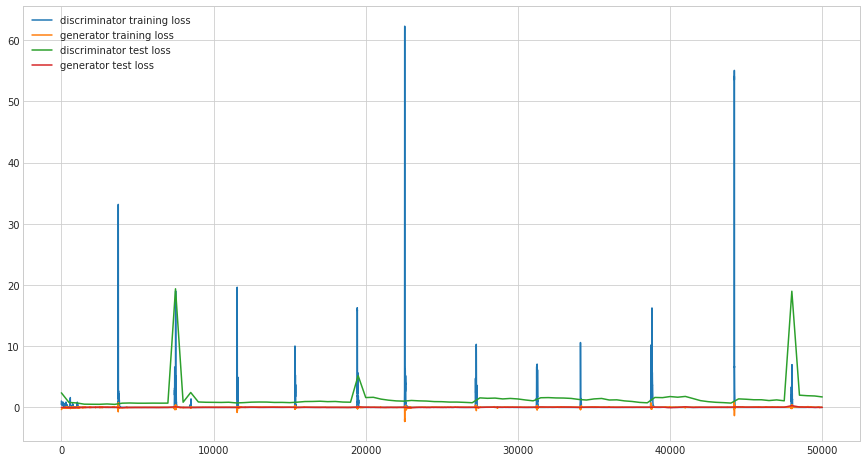

In [25]:
plot_losses(results)

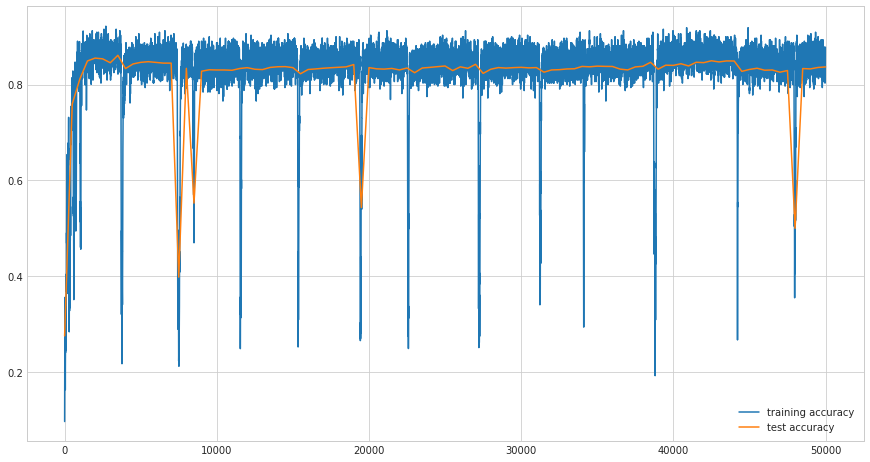

In [26]:
plot_accuracies(results)

In [27]:
results = run_test('coulomb-gan-500-periodic.pkl', num_labeled_examples=500, periodic_labeled_batch=True)

0 2.3437798 -0.01639007 0.3085
500 1.0909202 0.005895272 0.66439986
1000 0.461527 0.032867003 0.8759
1500 0.60862345 0.019729344 0.84190005
2000 0.47125146 0.0031248718 0.8774
2500 0.5949607 0.032971226 0.8571
3000 0.52414167 0.034108013 0.8723001
3500 0.56555736 0.0669647 0.86770004
4000 0.526367 0.06215146 0.87409997
4500 0.53091806 0.050579935 0.8753
5000 1.167859 0.0033460301 0.70030004
5500 0.6720181 0.039595924 0.8646
6000 0.6497332 0.04343314 0.8674
6500 0.76259804 0.0033112701 0.8524
7000 0.6483116 0.047204636 0.87499994
7500 0.62403196 0.046467986 0.8744
8000 0.60456824 0.046630263 0.8742
8500 1.2662317 -0.08120374 0.694
9000 0.9147999 0.044137944 0.86410004
9500 1.0304776 0.027875153 0.8592999
10000 0.77008027 0.01453122 0.8743
10500 0.7090959 0.043613028 0.86920005
11000 0.72880006 0.040799443 0.87149996
11500 0.6704873 0.049526624 0.8699
12000 0.63404876 0.04801971 0.8757
12500 6.7178416 0.017191634 0.53199995
13000 0.98341125 0.028437113 0.84409994
13500 0.86185014 0.03406

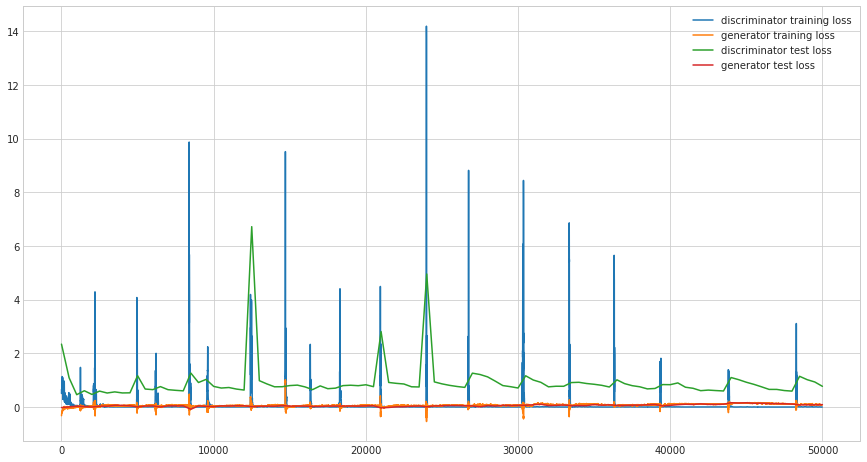

In [28]:
plot_losses(results)

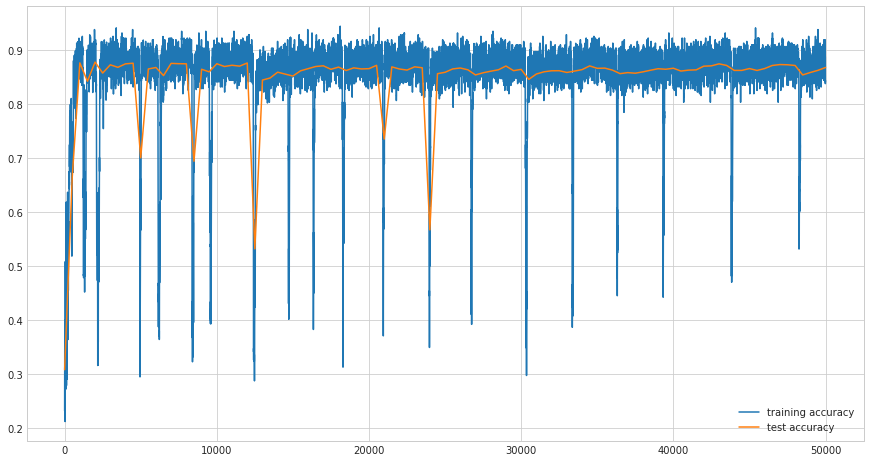

In [29]:
plot_accuracies(results)

In [30]:
results = run_test('coulomb-gan-1000-periodic.pkl', num_labeled_examples=1000, periodic_labeled_batch=True)

0 2.266588 -0.05455391 0.24589998
500 0.9872978 -0.058170103 0.72099996
1000 0.43634716 0.00042060603 0.88229996
1500 0.62199026 0.044448882 0.8442001
2000 0.47820464 0.020651309 0.89299995
2500 0.43526924 0.008570197 0.89619994
3000 0.49616662 0.07181996 0.8858
3500 0.4768493 0.020708125 0.89809996
4000 0.47989395 0.04304297 0.89419997
4500 0.45304734 0.020853288 0.8969999
5000 0.48043323 0.036600336 0.89999986
5500 0.4687891 0.012192271 0.89689994
6000 0.4521641 0.019754484 0.90089995
6500 0.6211671 0.008666446 0.9006001
7000 0.52590805 0.0050016646 0.9055999
7500 0.5115517 0.018617947 0.90090007
8000 1.3335655 0.0074944277 0.757
8500 0.61644894 0.0061940197 0.89799994
9000 0.54480517 0.002829883 0.9015001
9500 0.520011 0.00811215 0.90139997
10000 0.5514512 0.008090422 0.8990999
10500 0.47604993 0.015099823 0.9032999
11000 0.45327538 0.015351687 0.905
11500 0.5297481 0.006156825 0.8960999
12000 0.5095234 0.0012160565 0.9000001
12500 0.50897795 0.006334865 0.9013001
13000 0.45551604 0

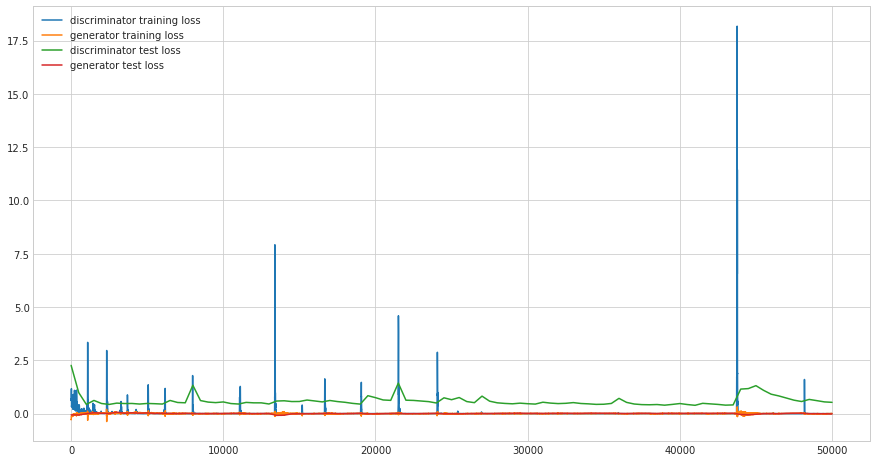

In [31]:
plot_losses(results)

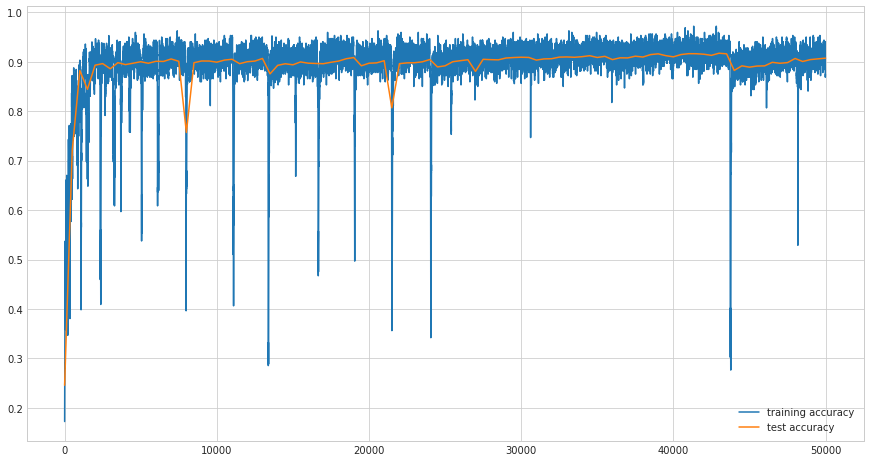

In [32]:
plot_accuracies(results)